# Non-daily #1589 
* To get data for another date besides 4/16/2025 (which is a Wednesday): 
    * Update the dates in `gtfs_funnel/update_vars`
    * `python stop_times_with_direction.py`
    * `python schedule_stats_by_route_direction` 

In [1]:
import re

import geopandas as gpd
import google.auth
import merge_data
import merge_operator_service
import pandas as pd
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS, SCHED_GCS, SEGMENT_GCS

In [2]:
credentials, project = google.auth.default()

In [3]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [4]:
ROUTE_DIR_MONTH_FILE = GTFS_DATA_DICT.digest_tables.monthly_route_schedule_vp_report

In [5]:
route_dir_month_df = pd.read_parquet(f"{RT_SCHED_GCS}{ROUTE_DIR_MONTH_FILE}.parquet")

## Load data

In [6]:
mon_url = "gs://calitp-analytics-data/data-analyses/rt_vs_schedule/schedule_route_dir/schedule_route_direction_metrics_2025-04-14.parquet"

In [7]:
wed_url = "gs://calitp-analytics-data/data-analyses/rt_vs_schedule/schedule_route_dir/schedule_route_direction_metrics_2025-04-16.parquet"

In [8]:
fri_url = "gs://calitp-analytics-data/data-analyses/rt_vs_schedule/schedule_route_dir/schedule_route_direction_metrics_2025-04-18.parquet"

In [9]:
wed_df = gpd.read_parquet(
    wed_url,
    storage_options={"token": credentials.token},
).drop(columns=["geometry"])

In [10]:
mon_df = gpd.read_parquet(
    mon_url,
    storage_options={"token": credentials.token},
).drop(columns=["geometry"])

In [11]:
def load_dataset(url: str, date: list, include_common_shape: bool) -> pd.DataFrame:
    df = gpd.read_parquet(url, storage_options={"token": credentials.token})[
        [
            "schedule_gtfs_dataset_key",
            "route_id",
            "common_shape_id",
            "n_trips",
            "frequency",
            "geometry",
        ]
    ]

    # merge crosswalk
    crosswalk_df = merge_data.concatenate_crosswalk_organization(date)[
        ["caltrans_district", "schedule_gtfs_dataset_key", "analysis_name"]
    ]

    m1 = pd.merge(df, crosswalk_df, on="schedule_gtfs_dataset_key", how="left").drop(
        columns=["schedule_gtfs_dataset_key"]
    )

    if include_common_shape == True:
        m1["id_col"] = m1.analysis_name + "_" + m1.route_id + "_" + m1.common_shape_id
    else:
        m1["id_col"] = m1.analysis_name + "_" + m1.route_id

    # We dont' care about direction so this leads to many more duplicates
    m1 = m1.drop_duplicates(subset=["id_col"]).reset_index(drop=True)

    m1 = m1[
        [
            "caltrans_district",
            "analysis_name",
            "id_col",
            "route_id",
            "common_shape_id",
            "n_trips",
            "frequency",
            "geometry",
        ]
    ]
    return m1

## Including `common_shape_id` as a way to identify unique routes 

In [12]:
mon_df2 = load_dataset(mon_url, ["2025-04-14"], True)

In [13]:
wed_df2 = load_dataset(wed_url, ["2025-04-16"], True)

In [14]:
m1 = pd.merge(
    mon_df2,
    wed_df2,
    on=["id_col"],
    suffixes=["monday_", "wednesday_"],
    how="outer",
    indicator=True,
)

In [15]:
m1._merge = m1._merge.str.replace("left_only", "_monday_only").str.replace(
    "right_only", "_wednesday_only"
)

In [16]:
m1._merge.value_counts()

both               3964
_monday_only         83
_wednesday_only      77
Name: _merge, dtype: int64

In [20]:
def compare_dates(df: pd.DataFrame, day: str, subset_cols: list) -> pd.DataFrame:
    df2 = df.loc[df._merge == day][subset_cols].drop_duplicates()

    df2["day"] = day

    days = ["monday", "wednesday"]
    for day in days:
        df2.columns = df2.columns.str.replace(f"{day}_", "", regex=False)

    return df2

### Which routes are they?

In [21]:
mon_routes = compare_dates(
    m1,
    "_monday_only",
    [
        "caltrans_districtmonday_",
        "analysis_namemonday_",
        "route_idmonday_",
        "common_shape_idmonday_",
        "n_tripsmonday_",
        "id_col",
    ],
)

In [22]:
wed_routes = compare_dates(
    m1,
    "_wednesday_only",
    [
        "caltrans_districtwednesday_",
        "analysis_namewednesday_",
        "route_idwednesday_",
        "common_shape_idwednesday_",
        "n_tripswednesday_",
        "id_col",
    ],
)

In [23]:
routes_df = pd.concat([mon_routes, wed_routes], axis=0).drop_duplicates()

In [24]:
routes_df.columns

Index(['caltrans_district', 'analysis_name', 'route_id', 'common_shape_id',
       'n_trips', 'id_col', 'day'],
      dtype='object')

In [25]:
routes_gdf = pd.merge(geometries_df, routes_df, how="inner")

### Look at Specific Routes

#### Culver City 
* Only one direction on Monday and Wednesday.

In [26]:
def specific_route(route: str):
    print("Monday")
    display(mon_df.loc[mon_df.route_id == route])
    print("Wednesday")
    display(wed_df.loc[wed_df.route_id == route])

    display(
        routes_gdf.loc[routes_gdf.route_id == route].explore(
            "day", width=600, height=400, tiles="CartoDB positron"
        )
    )

In [27]:
specific_route("5C2")

Monday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
9,4b317fc27dde351e12253d46cedd8df0,5C2,1.00,shp-5C2-56,36.67,Southbound,3.04,3,all_day,0.12
10,4b317fc27dde351e12253d46cedd8df0,5C2,1.00,shp-5C2-56,36.67,Southbound,3.04,1,offpeak,0.06
11,4b317fc27dde351e12253d46cedd8df0,5C2,1.00,shp-5C2-56,36.67,Southbound,3.04,2,peak,0.25


Wednesday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
1574,4b317fc27dde351e12253d46cedd8df0,5C2,1.00,shp-5C2-06,37.50,Northbound,3.26,2,all_day,0.08
1575,4b317fc27dde351e12253d46cedd8df0,5C2,1.00,shp-5C2-06,37.50,Northbound,3.26,1,offpeak,0.06
1576,4b317fc27dde351e12253d46cedd8df0,5C2,1.00,shp-5C2-06,37.50,Northbound,3.26,1,peak,0.12


#### City of Glendora MiddayShuttle:Orange 	
* Missing direction 1 for both Monday and Wednesday
* Different `common_shape_id` values.

In [28]:
specific_route("MiddayShuttle:Orange")

Monday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
1817,a532ea8697dcb081f15f8e712f6cf8bd,MiddayShuttle:Orange,0.00,p_901434,72.50,Southbound,1.78,2,all_day,0.08
1818,a532ea8697dcb081f15f8e712f6cf8bd,MiddayShuttle:Orange,0.00,p_901434,72.50,Southbound,1.78,2,offpeak,0.12


Wednesday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
589,a532ea8697dcb081f15f8e712f6cf8bd,MiddayShuttle:Orange,0.00,p_901421,25.00,Southbound,2.45,2,all_day,0.08
590,a532ea8697dcb081f15f8e712f6cf8bd,MiddayShuttle:Orange,0.00,p_901421,25.00,Southbound,2.45,1,offpeak,0.06
591,a532ea8697dcb081f15f8e712f6cf8bd,MiddayShuttle:Orange,0.00,p_901421,25.00,Southbound,2.45,1,peak,0.12


#### City of Fairfield 	
* Different shape id for each direction
* Genuinely no data for Monday

In [29]:
specific_route("8T")

Monday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency


Wednesday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
101,0f5e1b251db53223200c5bfc365d33f2,8T,1.00,p_1434332,28.00,Southbound,6.17,4,all_day,0.17
102,0f5e1b251db53223200c5bfc365d33f2,8T,1.00,p_1434332,28.00,Southbound,6.17,4,peak,0.50
943,0f5e1b251db53223200c5bfc365d33f2,8T,0.00,p_1435106,37.00,Northbound,2.73,4,all_day,0.17
944,0f5e1b251db53223200c5bfc365d33f2,8T,0.00,p_1435106,37.00,Northbound,2.73,4,peak,0.50


#### AC Transit
* Same route, different `common_shape_id` value across different days for Westbound.

In [30]:
specific_route("672")

Monday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
5509,c499f905e33929a641f083dad55c521e,672,0.00,shp-672-52,34.00,Westbound,3.70,1,all_day,0.04
5510,c499f905e33929a641f083dad55c521e,672,0.00,shp-672-52,34.00,Westbound,3.70,1,offpeak,0.06
5598,c499f905e33929a641f083dad55c521e,672,1.00,shp-672-01,35.00,Eastbound,3.91,1,all_day,0.04
5599,c499f905e33929a641f083dad55c521e,672,1.00,shp-672-01,35.00,Eastbound,3.91,1,peak,0.12


Wednesday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
5366,c499f905e33929a641f083dad55c521e,672,1.00,shp-672-01,35.00,Eastbound,3.91,1,all_day,0.04
5367,c499f905e33929a641f083dad55c521e,672,1.00,shp-672-01,35.00,Eastbound,3.91,1,peak,0.12
5458,c499f905e33929a641f083dad55c521e,672,0.00,shp-672-51,34.00,Westbound,3.70,1,all_day,0.04
5459,c499f905e33929a641f083dad55c521e,672,0.00,shp-672-51,34.00,Westbound,3.70,1,offpeak,0.06


#### Foothill Transit
* Has a lot of funkiness with the routes
* Route 291: different shape_id even on the same date for the same route.

In [31]:
specific_route("291")

Monday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
3664,f74424acf8c41e4c1e9fd42838c4875c,291,1.00,13851_shp,40.15,Southbound,3.75,59,all_day,2.46
3665,f74424acf8c41e4c1e9fd42838c4875c,291,1.00,13851_shp,40.15,Southbound,3.75,31,offpeak,1.94
3666,f74424acf8c41e4c1e9fd42838c4875c,291,1.00,13851_shp,40.15,Southbound,3.75,28,peak,3.50
3729,f74424acf8c41e4c1e9fd42838c4875c,291,0.00,13859_shp,44.19,Northbound,3.80,59,all_day,2.46
3730,f74424acf8c41e4c1e9fd42838c4875c,291,0.00,13859_shp,44.19,Northbound,3.80,31,offpeak,1.94
3731,f74424acf8c41e4c1e9fd42838c4875c,291,0.00,13859_shp,44.19,Northbound,3.80,28,peak,3.50


Wednesday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
9874,f74424acf8c41e4c1e9fd42838c4875c,291,1.00,14078_shp,40.15,Southbound,3.75,59,all_day,2.46
9875,f74424acf8c41e4c1e9fd42838c4875c,291,1.00,14078_shp,40.15,Southbound,3.75,31,offpeak,1.94
9876,f74424acf8c41e4c1e9fd42838c4875c,291,1.00,14078_shp,40.15,Southbound,3.75,28,peak,3.50
9892,f74424acf8c41e4c1e9fd42838c4875c,291,0.00,14083_shp,44.19,Northbound,3.80,59,all_day,2.46
9893,f74424acf8c41e4c1e9fd42838c4875c,291,0.00,14083_shp,44.19,Northbound,3.80,31,offpeak,1.94
9894,f74424acf8c41e4c1e9fd42838c4875c,291,0.00,14083_shp,44.19,Northbound,3.80,28,peak,3.50


In [32]:
specific_route("699")

Monday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
3577,f74424acf8c41e4c1e9fd42838c4875c,699,1.00,13951_shp,79.22,Westbound,33.63,18,all_day,0.75
3578,f74424acf8c41e4c1e9fd42838c4875c,699,1.00,13951_shp,79.22,Westbound,33.63,13,offpeak,0.81
3579,f74424acf8c41e4c1e9fd42838c4875c,699,1.00,13951_shp,79.22,Westbound,33.63,5,peak,0.62
3640,f74424acf8c41e4c1e9fd42838c4875c,699,0.00,13950_shp,87.38,Eastbound,1.47,16,all_day,0.67
3641,f74424acf8c41e4c1e9fd42838c4875c,699,0.00,13950_shp,87.38,Eastbound,1.47,2,offpeak,0.12
3642,f74424acf8c41e4c1e9fd42838c4875c,699,0.00,13950_shp,87.38,Eastbound,1.47,14,peak,1.75


Wednesday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
9826,f74424acf8c41e4c1e9fd42838c4875c,699,1.00,14060_shp,79.22,Westbound,33.63,18,all_day,0.75
9827,f74424acf8c41e4c1e9fd42838c4875c,699,1.00,14060_shp,79.22,Westbound,33.63,13,offpeak,0.81
9828,f74424acf8c41e4c1e9fd42838c4875c,699,1.00,14060_shp,79.22,Westbound,33.63,5,peak,0.62
10019,f74424acf8c41e4c1e9fd42838c4875c,699,0.00,14084_shp,87.38,Eastbound,1.47,16,all_day,0.67
10020,f74424acf8c41e4c1e9fd42838c4875c,699,0.00,14084_shp,87.38,Eastbound,1.47,2,offpeak,0.12
10021,f74424acf8c41e4c1e9fd42838c4875c,699,0.00,14084_shp,87.38,Eastbound,1.47,14,peak,1.75


#### Yuba Sutter Transit Authority
* Genuinely no data on Monday.

In [33]:
specific_route("6465")

Monday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency


Wednesday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
5750,0bcba4ddc5c10546f2e957a74f58b8ac,6465,1.00,p_110991,65.00,Southbound,13.57,2,all_day,0.08
5751,0bcba4ddc5c10546f2e957a74f58b8ac,6465,1.00,p_110991,65.00,Southbound,13.57,2,offpeak,0.12
5774,0bcba4ddc5c10546f2e957a74f58b8ac,6465,0.00,p_110993,65.00,Eastbound,24.23,2,all_day,0.08
5775,0bcba4ddc5c10546f2e957a74f58b8ac,6465,0.00,p_110993,65.00,Eastbound,24.23,1,offpeak,0.06
5776,0bcba4ddc5c10546f2e957a74f58b8ac,6465,0.00,p_110993,65.00,Eastbound,24.23,1,peak,0.12


#### San Mateo County Transit District 	
* Lots of shape_id even on the same date
* The shape_id values all yield the same route geometry when mapping this. 

In [34]:
# specific_route("40")

#### San Francisco Bay Ferry and Oakland Alameda Water Shuttle Schedule 	

In [92]:
 specific_route("OAS")

Monday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency


Wednesday


,schedule_gtfs_dataset_key,route_id,direction_id,common_shape_id,avg_scheduled_service_minutes,route_primary_direction,avg_stop_miles,n_trips,time_period,frequency
8213,82f30e22dafe8156367297eb9a316c57,OAS,1.00,p_1437866,7.00,Southbound,0.08,23,all_day,0.96
8214,82f30e22dafe8156367297eb9a316c57,OAS,1.00,p_1437866,7.00,Southbound,0.08,9,offpeak,0.56
8215,82f30e22dafe8156367297eb9a316c57,OAS,1.00,p_1437866,7.00,Southbound,0.08,14,peak,1.75
8225,82f30e22dafe8156367297eb9a316c57,OAS,0.00,p_1437867,7.00,Northbound,0.08,23,all_day,0.96
8226,82f30e22dafe8156367297eb9a316c57,OAS,0.00,p_1437867,7.00,Northbound,0.08,8,offpeak,0.50
8227,82f30e22dafe8156367297eb9a316c57,OAS,0.00,p_1437867,7.00,Northbound,0.08,15,peak,1.88


## Excluding `common_shape_id` as a way to identify unique routes 
* This is the solution.
* Often different `common_shape_id` values still correspond to the same geometry over the various dates

In [35]:
mon_df3 = load_dataset(mon_url, ["2025-04-14"], False)

In [36]:
mon_df3.shape

(2353, 8)

In [37]:
wed_df3 = load_dataset(wed_url, ["2025-04-16"], False)

In [38]:
wed_df3.shape

(2353, 8)

In [39]:
fri_df3 = load_dataset(fri_url, ["2025-04-18"], False)

In [40]:
fri_df3.shape

(2324, 8)

In [41]:
m2 = pd.merge(
    mon_df3,
    wed_df3,
    on=["id_col"],
    suffixes=["monday_", "wednesday_"],
    how="outer",
    indicator=True,
)

In [42]:
m2._merge = m2._merge.str.replace("left_only", "_monday_only").str.replace(
    "right_only", "_wednesday_only"
)

In [43]:
m2 = m2.rename(columns={"_merge": "merge1"})

In [44]:
m2.merge1.value_counts()

both               2334
_monday_only         19
_wednesday_only      19
Name: merge1, dtype: int64

In [45]:
final_merge = pd.merge(
    m2,
    fri_df3,
    on=["id_col"],
    how="outer",
    indicator=True,
)

In [46]:
final_merge._merge = final_merge._merge.str.replace("right_only", "friday_only")

In [47]:
final_merge.route_on_dates = final_merge.merge1

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:206: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


In [48]:
final_merge.route_on_dates = final_merge.route_on_dates.str.replace(
    "both", "appears on Mon, Wed, and Fri"
)

### How many routes do not run daily?
* Funnily enough, there are no routes that only run on Friday.

In [49]:
final_merge.route_on_dates.value_counts()

appears on Mon, Wed, and Fri    2334
_monday_only                      19
_wednesday_only                   19
Name: merge1, dtype: int64

### Which agencies experience routes that appear on only one day? 

In [50]:
def compare_dates(df: pd.DataFrame, day: str, subset_cols: list) -> pd.DataFrame:
    df2 = df.loc[df.route_on_dates == day][subset_cols].drop_duplicates()

    df2["day"] = day

    days = ["monday", "wednesday"]
    for day in days:
        df2.columns = df2.columns.str.replace(f"{day}_", "", regex=False)

    return df2

In [51]:
mon_agencies = compare_dates(
    final_merge, "_monday_only", ["caltrans_districtmonday_", "analysis_namemonday_"]
)

In [52]:
wed_agencies = compare_dates(
    final_merge,
    "_wednesday_only",
    [
        "caltrans_districtwednesday_",
        "analysis_namewednesday_",
    ],
)

In [53]:
agencies_df = pd.concat([mon_agencies, wed_agencies], axis=0)

In [54]:
agencies_df.sort_values(by=["caltrans_district", "analysis_name"]).drop(columns=["day"])

,caltrans_district,analysis_name
2363,02 - Redding,Tehama County
71,03 - Marysville / Sacramento,Sacramento County
2370,03 - Marysville / Sacramento,Yuba-Sutter Transit Authority
2353,04 - Bay Area / Oakland,City of Fairfield
669,04 - Bay Area / Oakland,City of Petaluma
2371,04 - Bay Area / Oakland,San Francisco Bay Ferry and Oakland Alameda Water Shuttle Schedule
2354,05 - San Luis Obispo / Santa Barbara,San Luis Obispo Regional Transit Authority
2361,06 - Fresno / Bakersfield,Kings County Area Public Transit Agency
2358,07 - Los Angeles / Ventura,City of Artesia
15,07 - Los Angeles / Ventura,City of Gardena


In [55]:
agencies_df.caltrans_district.value_counts()

07 - Los Angeles / Ventura              3
04 - Bay Area / Oakland                 3
03 - Marysville / Sacramento            2
08 - San Bernardino / Riverside         2
11 - San Diego                          1
05 - San Luis Obispo / Santa Barbara    1
09 - Bishop                             1
10 - Stockton                           1
06 - Fresno / Bakersfield               1
12 - Santa Ana                          1
02 - Redding                            1
Name: caltrans_district, dtype: int64

### Which districts have the most operators with non-daily routes?

In [56]:
agencies_df.groupby(["caltrans_district"]).agg({"analysis_name": "nunique"}).rename(
    columns={"analysis_name": "# of operators with non-daily routes"}
).style.bar(subset=["# of operators with non-daily routes"], color="#d65f5f")

,# of operators with non-daily routes
caltrans_district,
02 - Redding,1
03 - Marysville / Sacramento,2
04 - Bay Area / Oakland,3
05 - San Luis Obispo / Santa Barbara,1
06 - Fresno / Bakersfield,1
07 - Los Angeles / Ventura,3
08 - San Bernardino / Riverside,2
09 - Bishop,1
10 - Stockton,1


### Which operators have the most routes that don't appear daily?

In [57]:
mon_routes2 = compare_dates(
    final_merge,
    "_monday_only",
    [
        "caltrans_districtmonday_",
        "analysis_namemonday_",
        "route_idmonday_",
        "n_tripsmonday_",
        "id_col",
    ],
)

In [58]:
wed_routes2 = compare_dates(
    final_merge,
    "_wednesday_only",
    [
        "caltrans_districtwednesday_",
        "analysis_namewednesday_",
        "route_idwednesday_",
        "n_tripswednesday_",
        "id_col",
    ],
)

In [59]:
routes_df2 = pd.concat([mon_routes2, wed_routes2], axis=0).drop_duplicates()

In [60]:
routes_df2.groupby(
    [
        "caltrans_district",
        "analysis_name",
    ]
).agg(
    {"id_col": "nunique"}
).rename(columns={"id_col": "unique_routes"}).style.bar(
    subset=["unique_routes"], color="#d65f5f"
)

### How many trips are we missing if we are only downloading one day's worth of data?

In [61]:
routes_df2.groupby(
    [
        "day",
    ]
).agg(
    {"n_trips": "sum"}
).style.bar(subset=["n_trips"], color="#d65f5f")

,n_trips
day,
_monday_only,140.000000
_wednesday_only,250.000000


### Which routes are missing?

In [62]:
routes_subset = [
    "caltrans_district",
    "analysis_name",
    "day",
    "route_id",
]

In [63]:
routes_df2[routes_subset].sort_values(by=routes_subset)

,caltrans_district,analysis_name,day,route_id
2363,02 - Redding,Tehama County,_wednesday_only,1292
71,03 - Marysville / Sacramento,Sacramento County,_monday_only,Delta
631,03 - Marysville / Sacramento,Sacramento County,_monday_only,GaltSac
120,03 - Marysville / Sacramento,Sacramento County,_monday_only,Hwy 99
2370,03 - Marysville / Sacramento,Yuba-Sutter Transit Authority,_wednesday_only,6465
2353,04 - Bay Area / Oakland,City of Fairfield,_wednesday_only,8T
669,04 - Bay Area / Oakland,City of Petaluma,_monday_only,301
2371,04 - Bay Area / Oakland,San Francisco Bay Ferry and Oakland Alameda Water Shuttle Schedule,_wednesday_only,OAS
2369,05 - San Luis Obispo / Santa Barbara,San Luis Obispo Regional Transit Authority,_wednesday_only,10866826
2356,05 - San Luis Obispo / Santa Barbara,San Luis Obispo Regional Transit Authority,_wednesday_only,10866849


### Evaluate Southern California Regional Rail Authority more
* We only have data for Monday

In [86]:
socal_monday = mon_gdf.loc[mon_gdf.analysis_name ==  "Southern California Regional Rail Authority"]

<Axes: >

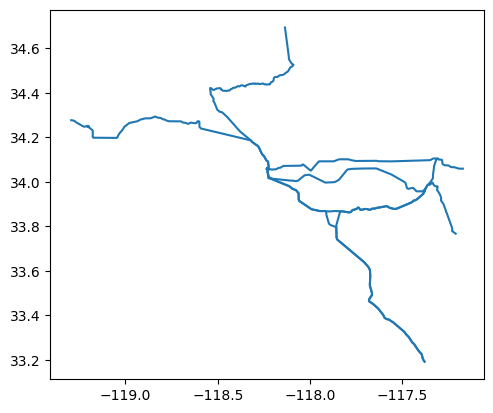

In [89]:
socal_monday.plot()

In [87]:
socal_wed = wed_gdf.loc[wed_gdf.analysis_name == "Southern California Regional Rail Authority"]

ValueError: aspect must be finite and positive 

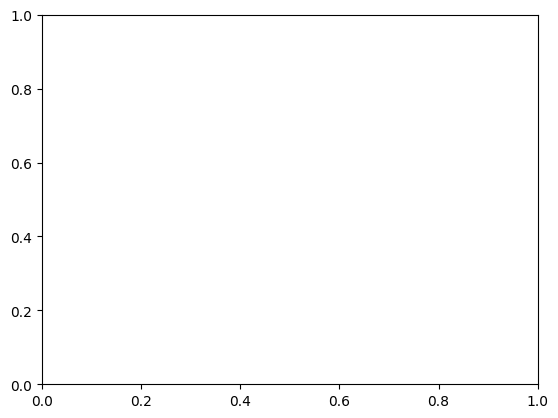

In [88]:
socal_wed.plot()

In [64]:
mon_routes2.loc[
    mon_routes2.analysis_name == "Southern California Regional Rail Authority"
][["route_id", "day"]].drop_duplicates(subset=["route_id", "day"])

,route_id,day
81,Riverside Line,_monday_only
100,Orange County Line,_monday_only
115,Ventura County Line,_monday_only
136,91 Line,_monday_only
321,Antelope Valley Line,_monday_only
418,Inland Emp.-Orange Co. Line,_monday_only
479,San Bernardino Line,_monday_only


In [65]:
wed_routes2.loc[
    wed_routes2.analysis_name == "Southern California Regional Rail Authority"
][["route_id", "day"]].drop_duplicates(subset=["route_id", "day"])

,route_id,day


### See where Redding (RABA) route 19 is.
* It's still missing.

In [66]:
wed_df3.loc[wed_df3.route_id == "19"].drop(columns=["geometry"])

,caltrans_district,analysis_name,id_col,route_id,common_shape_id,n_trips,frequency
1026,04 - Bay Area / Oakland,Alameda-Contra Costa Transit District,Alameda-Contra Costa Transit District_19,19,shp-19-53,16,0.67
1301,04 - Bay Area / Oakland,San Mateo County Transit District,San Mateo County Transit District_19,19,190037,1,0.04
1404,05 - San Luis Obispo / Santa Barbara,UCSC and City of Santa Cruz Beach Shuttle,UCSC and City of Santa Cruz Beach Shuttle_19,19,shp-19-04,58,2.42
1426,04 - Bay Area / Oakland,Central Contra Costa Transit Authority,Central Contra Costa Transit Authority_19,19,47173,9,0.38
1640,04 - Bay Area / Oakland,City and County of San Francisco,City and County of San Francisco_19,19,1950,67,2.79
2062,08 - San Bernardino / Riverside,Riverside Transit Agency,Riverside Transit Agency_19,19,shp-19-66,57,2.38


In [67]:
mon_df3.loc[mon_df3.route_id == "19"].drop(columns=["geometry"])

,caltrans_district,analysis_name,id_col,route_id,common_shape_id,n_trips,frequency
1076,04 - Bay Area / Oakland,Alameda-Contra Costa Transit District,Alameda-Contra Costa Transit District_19,19,shp-19-03,16,0.67
1288,04 - Bay Area / Oakland,San Mateo County Transit District,San Mateo County Transit District_19,19,190037,1,0.04
1427,05 - San Luis Obispo / Santa Barbara,UCSC and City of Santa Cruz Beach Shuttle,UCSC and City of Santa Cruz Beach Shuttle_19,19,shp-19-04,58,2.42
1442,04 - Bay Area / Oakland,Central Contra Costa Transit Authority,Central Contra Costa Transit Authority_19,19,47172,8,0.33
1650,04 - Bay Area / Oakland,City and County of San Francisco,City and County of San Francisco_19,19,1950,67,2.79
2117,08 - San Bernardino / Riverside,Riverside Transit Agency,Riverside Transit Agency_19,19,shp-19-66,57,2.38


### Evaluate San Luis Obispo Regional Transit Authority more
* The routes look exactly the same??

In [79]:
mon_gdf = mon_df3[["analysis_name", "geometry", "route_id"]]
wed_gdf = wed_df3[["analysis_name", "geometry", "route_id"]]

In [80]:
slo_monday = mon_gdf.loc[mon_gdf.analysis_name == "San Luis Obispo Regional Transit Authority"]

<Axes: >

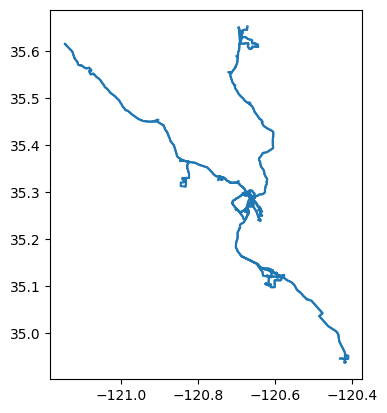

In [84]:
slo_monday.plot()

In [82]:
slo_wed = wed_gdf.loc[wed_gdf.analysis_name == "San Luis Obispo Regional Transit Authority"]

<Axes: >

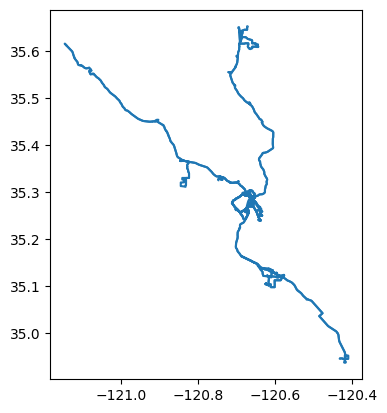

In [85]:
slo_wed.plot()

## Conclusion
* Method: disregarded direction because we want this analysis on the route grain to get a general sense of which routes are missing. 
    * Adding on `common_shape_id` doesn't help because some operators use new `common_shape_id` values for the same route on different days and even throughout the same day. This is shown through the fact the routes look exactly the same on a map. 
    * Created a new column called `id_col` that combines the `analysis_name` with `route_id` columns to see which routes are missing between each day.
* There were no routes that ran ony on Friday. 
* Monday and Wednesday see equal number of missing routes, 19 each.
    * However, 6 of the 19 missing routes on Monday are from GreyHound/FlixBus which I am not sure if it matters as much.
    * There are operators that only capture data for a route for one day - either by mistake or the route doesn't run.
* Recommendation: keep downloading only Wednesday data. 

In [91]:
routes_df2.loc[routes_df2.analysis_name.str.contains("FlixBus")].shape

(6, 6)